# CWatM Data

In [1]:
from typing import Union, List, Any, Tuple, Dict, DefaultDict, Optional
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd
import geopandas as gpd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
data_dir = Path("/datadrive/data")
ds = dynamic = xr.open_dataset(data_dir / "202108171219_cwatm_ORIG_GRID.nc")
static = xr.open_dataset(data_dir / "cwatm_static.nc")

# ensure aligned
ds = ds.rename({"basin": "station_id"})
static = static.rename({"basin": "station_id"})
ds["station_id"] = ds["station_id"].astype(int)
static["station_id"] = static["station_id"].astype(int)

In [3]:
from scripts.cwatm_data.ldd_draft import vectorize_rowcol_to_latlon_points, load_basin_file_ldd
cwat_dir = data_dir / "CWATM"
shapefile_out_dir = cwat_dir / "shapefile"

points = gpd.read_file(cwat_dir / "gauge_points/gauge_points.shp").set_index("index")
ldd_gdf = gpd.read_file(shapefile_out_dir / "catchment_boundaries.shp").set_index("value")

In [4]:
ds

<xarray.Dataset>
Dimensions:            (station_id: 864, time: 9131)
Coordinates:
  * time               (time) datetime64[ns] 1990-01-01 ... 2014-12-31
  * station_id         (station_id) int64 0 1 2 3 4 5 ... 859 860 861 862 863
Data variables:
    Precipitation      (station_id, time) float32 ...
    Tavg               (station_id, time) float32 ...
    discharge          (station_id, time) float32 ...
    channelStorage     (station_id, time) float32 ...
    storGroundwater    (station_id, time) float32 ...
    sum_interceptStor  (station_id, time) float32 ...
    SnowCover          (station_id, time) float32 ...
    sum_w1             (station_id, time) float32 ...
    sum_w2             (station_id, time) float32 ...
    sum_w3             (station_id, time) float32 ...

# Look at gauge data

In [5]:
large_sids = static.sortby("area")["area"][-3:].station_id.values
small_sids = static.sortby("area")["area"][:3].station_id.values

<AxesSubplot:>

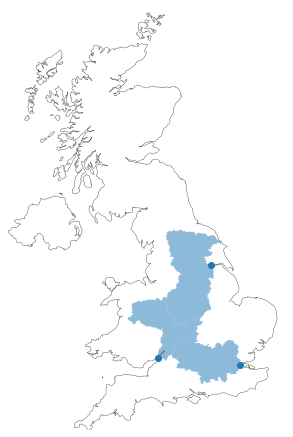

In [6]:
from scripts.geospatial import initialise_gb_spatial_plot


def spatial_plot(sids: Union[List[int], int]):
    sids = [sids] if isinstance(sids, int) else sids
    ax = initialise_gb_spatial_plot()
    ldd_gdf.loc[sids].plot(ax=ax, alpha=0.5)
    points.loc[sids].plot(ax=ax);
    return ax


spatial_plot(large_sids)

In [7]:
lg_df = (ds.sel(station_id=large_sids)["discharge"].median("time")).to_dataframe()
sm_df = (ds.sel(station_id=small_sids)["discharge"].median("time")).to_dataframe()

<AxesSubplot:>

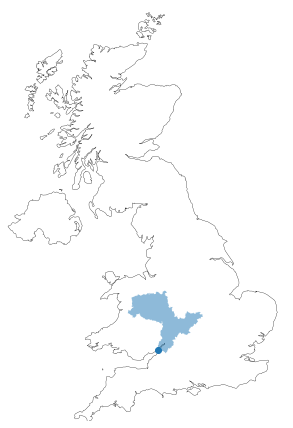

In [8]:
spatial_plot(688)

In [9]:
q_med = ds.median(dim="time")["discharge"]

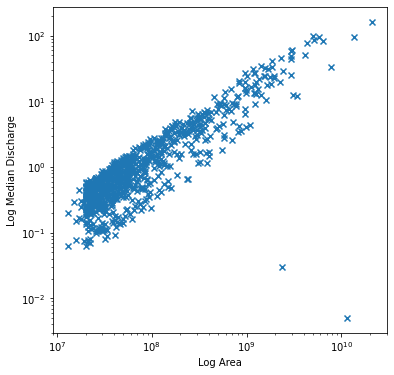

In [10]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(static["area"], q_med, marker="x")

log = True
if log:
    plt.yscale("log")
    plt.xscale("log")

ax.set_xlabel("Area" if not log else "Log Area")
ax.set_ylabel("Median Discharge" if not log else "Log Median Discharge");

In [11]:
# create dimensions to find outliers
X = np.log(np.vstack([static["area"].values, q_med.values]).T)
# mask nans
X = X[~np.isnan(X).any(axis=1)]

# fit outlier detection
algorithm = EllipticEnvelope()   # (contamination=0.002)
algorithm.fit(X)
y_pred = algorithm.predict(X)

f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], marker="x", color=["k" if y == 1 else "r" for y in y_pred])

# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 150),
                     np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 150))

Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=1, colors='black')

NameError: name 'EllipticEnvelope' is not defined

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.covariance import EllipticEnvelope

mask = (np.isfinite(q_med) & np.isfinite(static["area"])).values

# metrics.adjusted_mutual_info_score(static["area"][mask], q_med[mask])  
mi_score = mutual_info_regression(static["area"].values[mask].reshape(-1, 1), q_med.values[mask].reshape(-1, 1))
mi_score

# Is there enough information in the static info?

# Is there enough variance in inputs to describe variance in outputs?

In [ ]:
dynamic["Precipitation"]
dynamic["Tavg"]

# What about the soil moisture data?

In [ ]:
soil_vars = [v for v in dynamic.data_vars if "sum_w" in v]

p_corrs = xr.merge([
    xr.corr(dynamic[v], dynamic["Precipitation"], dim="time").rename(v)
    for v in dynamic.data_vars if "sum_w" in v
])
q_corrs = xr.merge([
    xr.corr(dynamic[v], dynamic["discharge"], dim="time").rename(v)
    for v in dynamic.data_vars if "sum_w" in v
])


f, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

ax = axs[0]
for v in soil_vars:
    data = p_corrs[v]
    ax.hist(data, bins=20, alpha=0.6, label=v, density=True)
ax.set_xlabel("Correlation with Precipitation")
ax.legend()

ax = axs[1]
for v in soil_vars:
    data = q_corrs[v]
    ax.hist(data, bins=20, alpha=0.6, label=v, density=True)
ax.set_xlabel("Correlation with Discharge, and Precipitaio")


sns.despine()